<a href="https://colab.research.google.com/github/jafetimbre/mib-fiesta/blob/master/src/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proiect la materia "*Stiinta datelor folosind Python*"

Studenti masteranzi, grupa **2**:
*   Muraru Madalina-Maria
*   Beresescu Mihai-Cristian
*   Imbre Jozsef-Jafet 


Acest proiect contine atat pregatirea, filtrarea si aranjarea datelor cat si analiza statistica a acestora.

In [160]:
import pandas as pd
import numpy as np
import math
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from matplotlib.lines import Line2D
import descartes

## 1. Descrierea si preprocesarea datelor

Pentru acest proiect s-au ales doua seturi de date cu o legatura intre acestea. Ambele contin entitati de proprietati aflate in jurul orasului Seattle, Washington, din Statele Unite ale Americii.

*   **Primul set de date**: contine inregistrari despre casele de vanzare in apropierea orasului
*   **Al doilea set de date**: contine inregistrari despre diferite unitati non rezidentiale (scoli, spitale, parcuri, etc.)



### 1.1 Descrierea seturilor de date

Atributele primului set de date (casele de vanzare) :

*   **price**: pretul cu care a fost vanduta locuinta
*   **bedrooms**:  numarul dormitoarelor
*   **bathrooms**: numarul de bai/dormitoare
*   **sqft_living**: suprafata utila locuibila
*   **sqft_lot**: ntreaga suprafata
*   **floors**: numarul etajelor
*   **waterfront**: locuinta pe malul unei ape
*   **condition**: gradul de confort per total
*   **grade**: nota locuintel dupa standardul Seattle
*   **yr_built**: anul construirii
*   **yr_renovated**: anul renovarii
*   **zipcode**: codul postal
*   **lat**: latitudinea
*   **long**: longitudinea

De sigur, aceste campuri se filtreaza si se efectueaza transformarile aferente (ex. sqrft -> m2)

In [149]:
housing_columns = [ 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
                    'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated' ,'zipcode', 'lat', 'long' ]

housing_data = pd.read_csv('https://raw.githubusercontent.com/jafetimbre/mib-fiesta/master/data/housing.csv', usecols=housing_columns)
housing_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,20141013T000000,221900,3,1.00,1180,5650,1.0,0,3,7,0,1955,0,98178,47.5112,-122.257
1,20141209T000000,538000,3,2.25,2570,7242,2.0,0,3,7,400,1951,1991,98125,47.7210,-122.319
2,20150225T000000,180000,2,1.00,770,10000,1.0,0,3,6,0,1933,0,98028,47.7379,-122.233
3,20141209T000000,604000,4,3.00,1960,5000,1.0,0,5,7,910,1965,0,98136,47.5208,-122.393
4,20150218T000000,510000,3,2.00,1680,8080,1.0,0,3,8,0,1987,0,98074,47.6168,-122.045


Al doilea set de date ales este un set ajutator, care contine anumite cladiri relevante din imprejurimile caselor primului dataset.

*   BuildingTypeName: Tipul Cladirii
*   PropertyTypeEPA: Propietatea (spital,restaurant,gradinita)
*   City: Orasul
*   Zip: Cod postal
*   Neighborhood: Cartierul
*   Longitude: Longitudinea
*   Latitude: Latitudinea

Asemanator cu primul set, se vor adauga doar campurile necesare. De exemplu, fiind vorba de orasul Seattle, coloana "City" se poate elimina. 


In [150]:
property_columns = [ 'BuildingTypeName', 'PropertyTypeEPA', 'City', 'Zip', 'Neighborhood', 'Latitude', 'Longitude' ]
property_data = pd.read_csv('https://raw.githubusercontent.com/jafetimbre/mib-fiesta/master/data/property_types.csv', usecols=property_columns)
property_data.head()

,BuildingTypeName,PropertyTypeEPA,City,Zip,Neighborhood,Latitude,Longitude
0,NonResidential,Hotel,SEATTLE,98101,DOWNTOWN,47.612190,-122.337997
1,NonResidential,Hotel,SEATTLE,98101,DOWNTOWN,47.613106,-122.333358
2,NonResidential,Hotel,SEATTLE,98101,DOWNTOWN,47.613349,-122.337699
3,NonResidential,Hotel,SEATTLE,98101,DOWNTOWN,47.614216,-122.336609
4,NonResidential,Hotel,SEATTLE,98121,DOWNTOWN,47.613754,-122.340924


De sigur, unele coloane au ramas incluse deoarece se vor folosi pentru a manipula/creea alte coloane, dupa care se vor elimina.

### 1.2 Preprocesarea si filtrarea datelor

Ca prim pas, se vor extrage codurile postale comune printr-o simpla intersectie. Aceasta informatie va ajuta la eliminarea inregistrarilor ne-relevante.

In [151]:
housing_data_ZIPs = housing_data.zipcode.unique()
property_data_ZIPs = property_data.Zip.unique()

zip_comon = list(set(housing_data_ZIPs).intersection(property_data_ZIPs))
print(zip_comon)

housing_data = housing_data[housing_data.zipcode.map(lambda e: e in zip_comon)]
property_data = property_data[property_data.Zip.map(lambda e: e in zip_comon)]

[98177, 98178, 98199, 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144, 98146, 98155]


Pentru primul set, se vor transpune unitatile de masura imperiale in unitati de masura metrice, prin formula:

> 1 ft<sup>2</sup> = 0.092 m<sup>2</sup>

Totodata se va transpune formatul de timp corespunzator.

In [152]:
housing_data.sqft_living = housing_data.sqft_living.apply(lambda e: round(e * 0.092))
housing_data.sqft_lot = housing_data.sqft_lot.apply(lambda e: round(e * 0.092))
housing_data.sqft_basement = housing_data.sqft_basement.apply(lambda e: round(e * 0.092))

housing_data.date = housing_data.date.apply(lambda e: datetime.datetime.strptime(e, '%Y%m%dT%H%M%S'))

Deoarece ne intereseaza doar entitatile non-rezidentiale din setul de date secundar, acestea se vor elimina complet, impreuna cu colanele specifice.

In [153]:
property_data = property_data[property_data.BuildingTypeName.map(lambda e: e in ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus'])]
property_data = property_data[property_data.City.map(lambda e: e == 'SEATTLE')]

property_data = property_data[property_data.PropertyTypeEPA.map(lambda e: e != 'Hotel')]
property_data = property_data.drop(['BuildingTypeName', 'City'], axis=1)

Pentru o consistenta in numele coloanelor, acestea se redenumesc.

In [154]:
housing_data = housing_data.rename(columns={'sqft_living': 'm2_living', 'sqft_lot':'m2_lot', 'sqft_basement':'m2_basement', 'zipcode':'zip'})
property_data = property_data.rename(columns={'PropertyTypeEPA': 'property_type', 'Zip': 'zip', 'Neighborhood':'neighborhood', 'Latitude': 'latitude', 'Longitude':'longitude'})

Inaintea exportari seturilor de date curatate si pregatite de analiza, se mai elimina valorile nule si se reseteaza indecsi de tabel.

In [155]:
housing_data.dropna(inplace=True)
housing_data.reset_index(drop=True)

property_data.dropna(inplace=True)
property_data.reset_index(drop=True)

housing_data.to_csv('housing_data_cleaned.csv', index = False, header=True)
property_data.to_csv('property_data_cleaned.csv', index = False, header=True)

Dupa curatarea datelor din acesta, primul set arata astfel:

In [156]:
housing_data.head()

,date,price,bedrooms,bathrooms,m2_living,m2_lot,floors,waterfront,condition,grade,m2_basement,yr_built,yr_renovated,zip,lat,long
0,2014-10-13,221900,3,1.00,109,520,1.0,0,3,7,0,1955,0,98178,47.5112,-122.257
1,2014-12-09,538000,3,2.25,236,666,2.0,0,3,7,37,1951,1991,98125,47.7210,-122.319
3,2014-12-09,604000,4,3.00,180,460,1.0,0,5,7,84,1965,0,98136,47.5208,-122.393
8,2015-04-15,229500,3,1.00,164,687,1.0,0,3,7,67,1960,0,98146,47.5123,-122.337
11,2014-05-27,468000,2,1.00,107,552,1.0,0,4,7,28,1942,0,98115,47.6900,-122.292


## 2. Generarea campurilor de interes

Pentru a elimina si a grupa tipurile de proprietati din setul secundar, se vor analiza valorile acestora.

In [105]:
property_data.head()

,property_type,zip,neighborhood,latitude,longitude
22,K-12 School,98118,SOUTHEAST,47.545701,-122.268584
28,K-12 School,98112,SHARED: CENTRAL & EAST,47.623094,-122.305389
30,K-12 School,98125,NORTH,47.710115,-122.293792
31,K-12 School,98109,MAGNOLIA / QUEEN ANNE,47.633032,-122.352457
32,Office,98103,LAKE UNION,47.663916,-122.331722


Pentru acest pas, obiectivul este de a calcula cu ajutorul cordonatelor geografice, numarul de utilitati(scoli, spitale, etc.) prezente in jurul unei proprietati, determinat de o raza **r**.

> **r** = 1 Km

Pentru aceasta se va folosi urmatoarea metoda:


In [106]:
def geographicDistance(a, b):
    """Calculates distance between two latitude-longitude coordinates."""
    R = 6378.1  # equatorial radius of Earth https://imagine.gsfc.nasa.gov/features/cosmic/earth_info.html
    lat1, lon1 = math.radians(a[0]), math.radians(a[1])
    lat2, lon2 = math.radians(b[0]), math.radians(b[1])
    return math.acos(math.sin(lat1) * math.sin(lat2) +
                        math.cos(lat1) * math.cos(lat2) * math.cos(lon1 - lon2)) * R

In [107]:
print(property_data.property_type.unique())

['K-12 School' 'Office' 'Supermarket/Grocery Store' 'Distribution Center'
 'Senior Care Community' 'Medical Office' 'Retail Store' 'Other'
 'Hospital (General Medical & Surgical)' 'College/University'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory'
 'Other/Specialty Hospital' 'Financial Office' 'Self-Storage Facility'
 'Non-Refrigerated Warehouse' 'Museum' 'Parking' 'Mixed Use Property'
 'Worship Facility' 'Data Center' 'Laboratory' 'Other - Services'
 'Strip Mall' 'Wholesale Club/Supercenter' 'Refrigerated Warehouse'
 'Other - Recreation' 'Lifestyle Center'
 'Other - Entertainment/Public Assembly' 'Manufacturing/Industrial Plant'
 'Restaurant' 'Social/Meeting Hall' 'Other - Education'
 'Fitness Center/Health Club/Gym' 'Other - Mall' 'Automobile Dealership'
 'Residential Care Facility'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)' 'Adult Education'
 'Library' 'Performing Arts' 'Movie Theater'
 'Outpatient Rehabilitation/Physical Therapy'
 'Personal Services (Health/Beaut

Tipurile de utilitati folisite sunt:


*   education (scoli, universitati, gradinita, etc.)
*   culture (librarii, muzee, sali de cultura, etc.)
*   store (magazine)
*   work (locuri de munca)
*   health (spitale)
*   services (parcari, restaorante, etc.)
*   recreation (sali fitness, parcuri, etc.)


In [108]:
property_types = {
    'education': ['K-12 School', 'College/University', 'Other - Education', 'Adult Education', 'Pre-school/Daycare'],
    'culture': ['Museum', 'Social/Meeting Hall', 'Library', 'Performing Arts', 'Movie Theater'],
    'store': ['Supermarket/Grocery Store', 'Retail Store', 'Strip Mall', 'Other - Mall', 'Automobile Dealership'],
    'work': ['Office', 'Financial Office', 'Bank Branch'],
    'health': ['Medical Office', 'Hospital (General Medical & Surgical)', 'Other/Specialty Hospital', 'Urgent Care/Clinic/Other Outpatient'],
    'services': ['Parking', 'Other - Services', 'Restaurant', 'Residential Care Facility', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Other - Utility'],
    'recreation': ['Other - Recreation', 'Lifestyle Center', 'Other - Entertainment/Public Assembly', 'Fitness Center/Health Club/Gym', 'Outpatient Rehabilitation/Physical Therapy']
}

filters = []
for i, el in property_types.items():
    filters.extend(el)

Pentru a optimiza timpul de procesare, se calculeaza doar distanta dintre casele care au diferenta cordonatelor mai mica de **0.05** grade. Se vor calcula astfel numarul de utilitati grupate in raza fiecarei proprietati si totodata numarul total de proprietati.

In [109]:
min_distance = 1           # km
compute_treshold = 0.05    # degrees

total = np.zeros(len(housing_data))

for key, values in property_types.items():
    counts = []

    filtered_prop_types = property_data[property_data['property_type'].isin(values)]

    for la_a, lo_a in zip(housing_data.lat, housing_data.long):
        num_count = 0
        for la_b, lo_b in zip(filtered_prop_types.latitude, filtered_prop_types.longitude):
            if (abs(la_a - la_b) > compute_treshold or abs(lo_a - lo_b) > compute_treshold):
                continue
            dist = geographicDistance((la_a, lo_a), (la_b, lo_b))
            if (dist <= min_distance):
                num_count += 1
        counts.append(num_count)
    
    housing_data[key] = counts
    total = np.add(total, counts)

housing_data['total_score'] = total

Dupa cum se vede, s-au generat aceste coloane auxiliare

In [110]:
housing_data[housing_data.columns[-8:]].head()

,education,culture,store,work,health,services,recreation,total_score
0,1,0,0,0,0,0,0,1.0
1,4,0,1,0,0,0,0,5.0
3,0,1,0,0,0,0,0,1.0
8,2,0,0,0,0,0,0,2.0
11,5,0,2,0,0,0,0,7.0


Pentru alte analize, s-a generat pretul pe metru patrat al proprietatior.

In [111]:
price_m2 = []

for price, m2_lot in zip(housing_data.price, housing_data.m2_lot):
    price_m2.append(round(price/m2_lot, 2))

housing_data['price_m2'] = price_m2 

## 3. Formularea ipotezelor

Ca puncte de analiza, s-au formulat urmatoarele ipoteze:


1.   Exista o zi a saptamanii sau luna a anului in care in general se vand mai multe proprietati? Daca da, care este?
2.   Au fost mai multe case construite pe malul apei inainte de anii 2000
3.   Pretul proprietatilor este afectat de pozitionarea caselor?
4.   Exista corelatie intre pretul pe metru patrat si numarul de utilitati din zona?
5.   



## 4. Analiza datelor

Analizele efectuate in acest proiect se rezuma la primul set de date, de sigur pregatit si sintetizat.

In [112]:
housing_data.head()

,date,price,bedrooms,bathrooms,m2_living,m2_lot,floors,waterfront,condition,grade,m2_basement,yr_built,yr_renovated,zip,lat,long,education,culture,store,work,health,services,recreation,total_score,price_m2
0,2014-10-13,221900,3,1.00,109,520,1.0,0,3,7,0,1955,0,98178,47.5112,-122.257,1,0,0,0,0,0,0,1.0,426.73
1,2014-12-09,538000,3,2.25,236,666,2.0,0,3,7,37,1951,1991,98125,47.7210,-122.319,4,0,1,0,0,0,0,5.0,807.81
3,2014-12-09,604000,4,3.00,180,460,1.0,0,5,7,84,1965,0,98136,47.5208,-122.393,0,1,0,0,0,0,0,1.0,1313.04
8,2015-04-15,229500,3,1.00,164,687,1.0,0,3,7,67,1960,0,98146,47.5123,-122.337,2,0,0,0,0,0,0,2.0,334.06
11,2014-05-27,468000,2,1.00,107,552,1.0,0,4,7,28,1942,0,98115,47.6900,-122.292,5,0,2,0,0,0,0,7.0,847.83


In [113]:
housing_data[['m2_living','price','m2_lot','price_m2','yr_built','floors','bedrooms']].describe()

,m2_living,price,m2_lot,price_m2,yr_built,floors,bedrooms
count,7981.000000,7.981000e+03,7981.000000,7981.000000,7981.000000,7981.000000,7981.000000
mean,165.649292,5.612638e+05,537.380028,1547.462523,1954.310112,1.492169,3.163889
std,73.781897,3.450309e+05,409.134820,1324.110323,33.313855,0.602185,1.054863
min,34.000000,8.200000e+04,48.000000,45.990000,1900.000000,1.000000,0.000000
25%,114.000000,3.620000e+05,335.000000,629.720000,1926.000000,1.000000,3.000000
50%,151.000000,4.780000e+05,471.000000,1138.060000,1949.000000,1.000000,3.000000
75%,202.000000,6.500000e+05,664.000000,1978.260000,1979.000000,2.000000,4.000000
max,1109.000000,7.700000e+06,8435.000000,22045.860000,2015.000000,3.500000,33.000000


Aplicand metoda describe() pentru a  evalua functiile statistice de baza, remarcam: o medie a pretului de 5,6M suprafata locuibila de 165 m<sup>2</sup>, pretul pe m<sup>2</sup> de 3460 dolari, numarul de bai si dormitoare 3.

> **<font color='DodgerBlue'>Ipoteza: </font>** Au fost mai multe case construite pe malul apei inainte de anii 2000. 
Pentru a observa acest lucru am construit un tabel pivot.

In [114]:
data = housing_data
data['decade'] = housing_data.apply(lambda row: (row.yr_built - row.yr_built%10)%100 if row.yr_built<2000 else round(row.yr_built,-1) , axis=1)

data.pivot_table('date',index='decade', columns='waterfront', aggfunc='count')

waterfront,0,1
decade,,
0,588.0,1.0
10,690.0,2.0
20,1041.0,5.0
30,363.0,7.0
40,1319.0,5.0
50,1240.0,12.0
60,452.0,5.0
70,255.0,1.0
80,202.0,2.0


> **<font color='Tomato'>Obs./Concluzie: </font>** In anii 50 au fost contruite cele mai multe case pe malul apei. 

Se vor analiza vanzarile proprietatilor pe zile si pe luni.

In [115]:
days = [ day[:3] for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'] ]
months = [ month[:3] for month in ['January','February','March','April','May','June','July','August','September','October','November','December'] ]

w = [ days[i.weekday()] for i in housing_data['date'] ]
m = [ months[i.month-1] for i in housing_data['date'] ]

sales_w_m = pd.DataFrame({'Day': w, 'Month': m, 'Price': housing_data.price}, index=housing_data.index)

Pentru a analiza aceste distributii, s-a transformat formatul de timp initial intr-un format text.

> **<font color='DodgerBlue'>Ipoteza: </font>** Exista o zi a saptamanii in care s-au vandut mai multe proprietati?


Text(0.5, 1.0, 'Numarul de proprietati vandute pe zilele saptamanii')

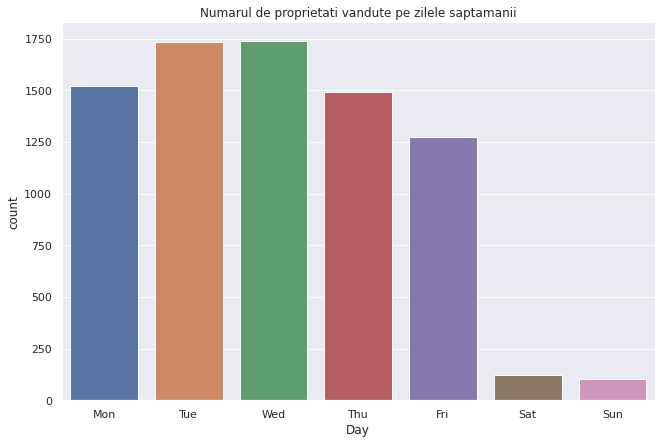

In [116]:
g = sns.catplot(data=sales_w_m, x='Day', kind="count", order=days)
g.fig.set_size_inches(10,6)
plt.title('Numarul de proprietati vandute pe zilele saptamanii')

> **<font color='Tomato'>Obs./Concluzie: </font>** Dupa cum se observa din graficul anterior, zilele in care au fost vandute cele mai multe case, sunt zilele in mijlocul saptamanii. In weekwnd nu au fost vandute foarte multe case.

> **<font color='DodgerBlue'>Ipoteza: </font>** Exista o luna anume in care s-au vandut mai multe proprietati? Dar in care vanzarile sunt putine?

Text(0.5, 1.0, 'Numarul de proprietati vandute pe luni')

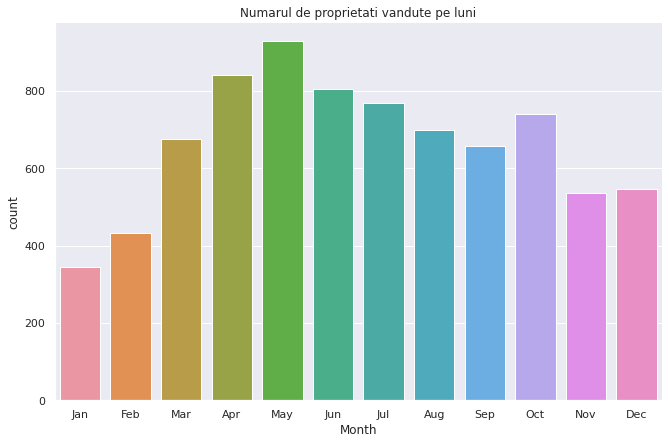

In [117]:
g = sns.catplot(data=sales_w_m, x='Month', kind="count", order=months)
g.fig.set_size_inches(10,6)
plt.title('Numarul de proprietati vandute pe luni')

> **<font color='Tomato'>Obs./Concluzie: </font>** Dupa cum se observa din graficul anterior, in general distributia vanzarilor pe luni este usor normala. Luna in care s-au vandut cele mai multe proprietati fiind luna **Mai** luna cu cele mai putine vanzari a fiind luna **Ianuarie**.


Initial, am reprezentat cu ajuorul unui scatterplot distributia pretului in functie de suprafata utila a locuintei si am remarcat cateva valori exceptionale (outliers) care ingreuneaza vizualizarea graficelor. Pentru o reprezentare mai concentrata am pastrat casele cu preturi mai mici sau egale cu 2M dolari, cu suprafata utila  pana in 450 metri patrati, 5 dormitoare si macar o baie.

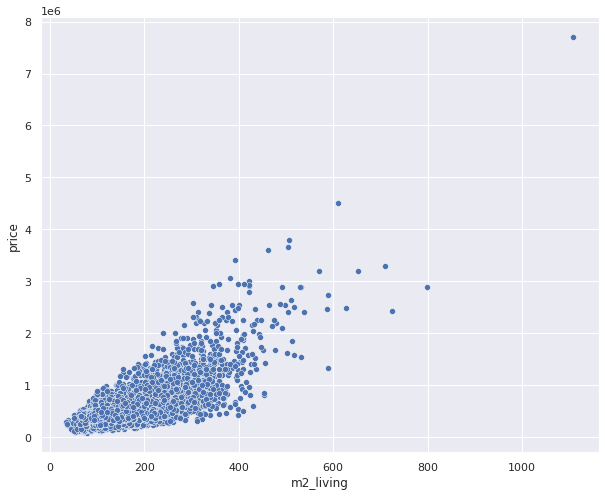

In [118]:
fg, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(x='m2_living', y='price',data=housing_data, ax=ax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


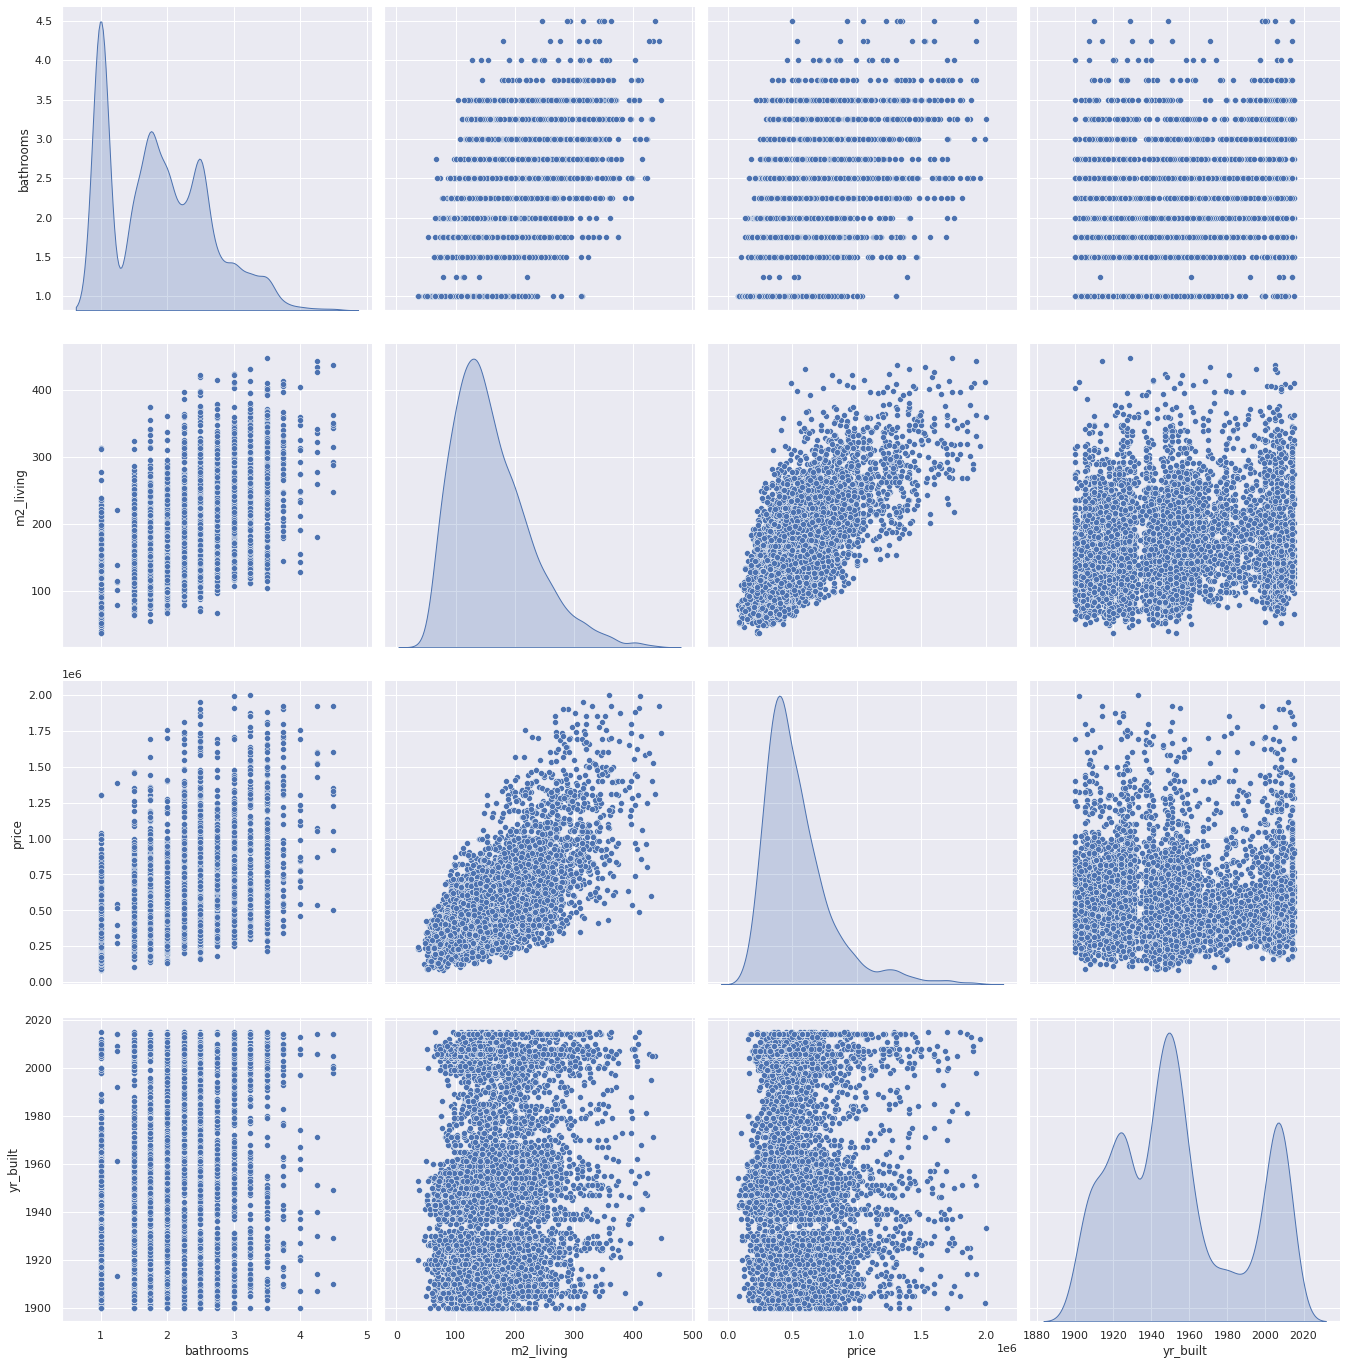

In [119]:
data_sc = data[(data.price<2000000) & (data.bedrooms<=5)&(data.m2_living<=450)&(data.bathrooms>=1)]
data_sc['price_m2'] = data_sc.apply(lambda row: round(row.price /row.m2_living), axis=1)

g = sns.pairplot(data_sc[['bathrooms','m2_living','price','yr_built']], diag_kind='kde',plot_kws={'alpha': 1})
g.fig.set_size_inches(20,20)
sns.set(rc={'figure.figsize':(30,20)})

> **<font color='Tomato'>Obs./Concluzie: </font>** Se poate observa din ultima figura, faptul ca intre anii 1960 si 2000 numarul proprietatilor construite a scazut comparativ cu alti ani.


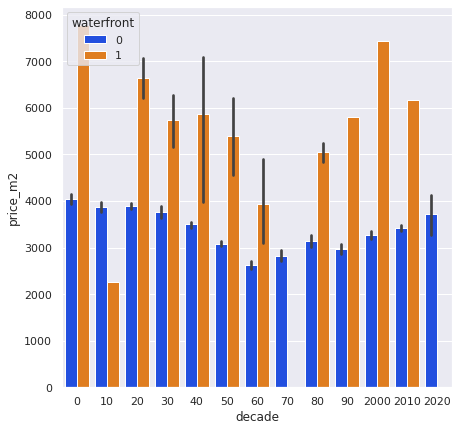

In [144]:
g = sns.barplot(x='decade', y='price_m2',data=data_sc, hue = 'waterfront',palette="bright")
sns.set(rc={'figure.figsize':(7,7)})

> **<font color='Tomato'>Obs./Concluzie: </font>** Pretul pe m<sup>2</sup> pentru casele din fiecare decada este aproape mereu mai mare pentru cele  pozitionate pe malul  apei


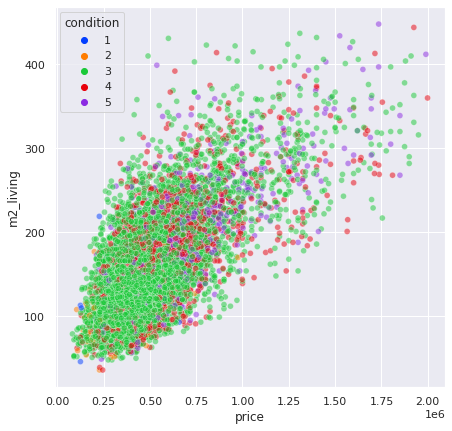

In [147]:
sns.scatterplot(data=data_sc, x="price", y="m2_living", hue="condition", palette="bright", alpha=0.5)

> **<font color='Tomato'>Obs./Concluzie: </font>** Dupa cum se observa din graficul anterior proprietatile avand scorul de conditie de valoarea 3 sunt mai raspandite.

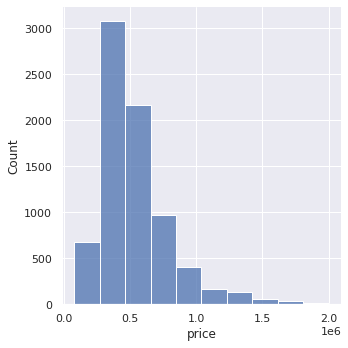

In [122]:
sns.displot(data_sc, x='price',bins=10)

> **<font color='Tomato'>Obs./Concluzie: </font>** Distributia nu este simetrica.Are un singur varf. Cele mai multe propietati au preturi intre 250.000 si 500.000 dolari .

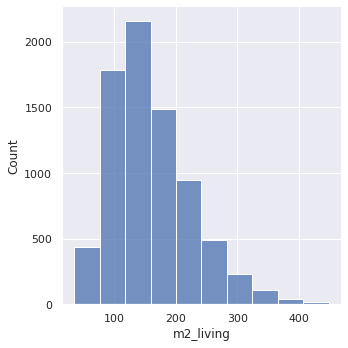

In [123]:
sns.displot(data_sc, x='m2_living',bins=10)

> **<font color='Tomato'>Obs./Concluzie: </font>** Distributia nu este simetrica.Cele mai multe case nu au o suprafata utila foarte mare.

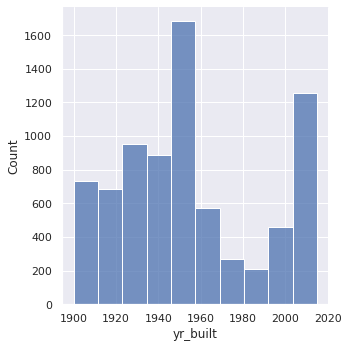

In [124]:
sns.displot(data_sc, x='yr_built',bins=10)

> **<font color='Tomato'>Obs./Concluzie: </font>**Exista mai multe varfuri.

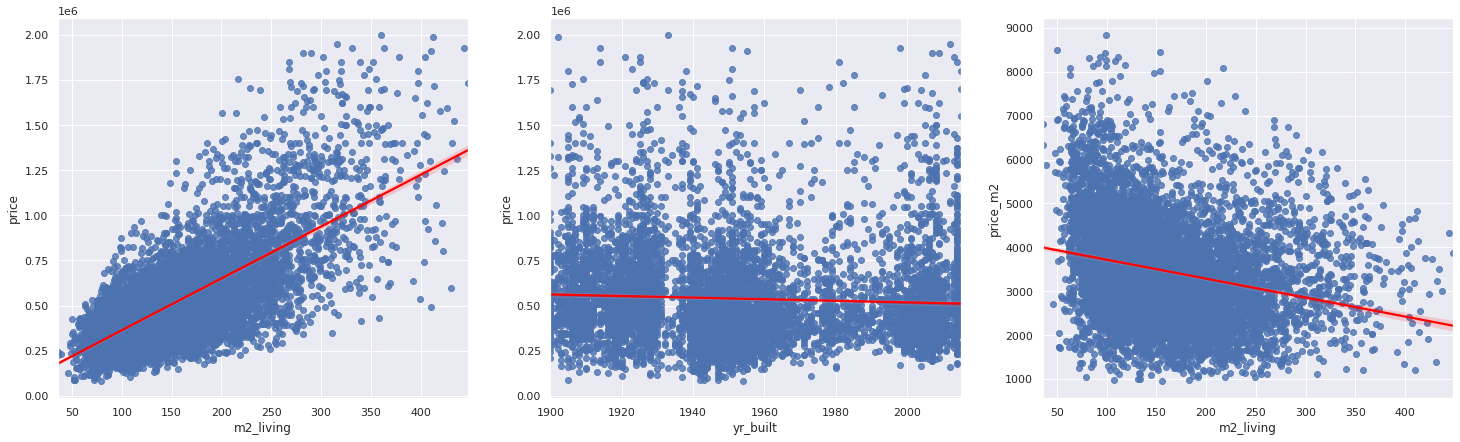

In [125]:
fig, axs = plt.subplots(ncols=3,nrows=1, figsize=(25,7))

sns.regplot(x='m2_living', y='price', data=data_sc, line_kws={"color": "red"}, ax=axs[0])
sns.regplot(x='yr_built', y='price', data=data_sc, line_kws={"color": "red"}, ax=axs[1])
sns.regplot(x='m2_living', y='price_m2', data=data_sc, line_kws={"color": "red"}, ax=axs[2])


> **<font color='Tomato'>Observatie: </font>** 
*   Intre pret si suprafata utila exista o corelatie directa.
*   Intre pret si anul construirii nu exista o corelatie.
*   Intre pretul pe m<sup>2</sup> si suprafata utilia exista o corelatie negativa.



In [126]:
housing_data.corr()['price'].sort_values()

store          -0.063147
yr_built       -0.060202
zip            -0.051411
long           -0.034832
decade         -0.004119
culture         0.006031
services        0.007102
health          0.024231
total_score     0.089917
work            0.106291
education       0.117265
recreation      0.119434
lat             0.119701
yr_renovated    0.158334
condition       0.159364
m2_lot          0.212048
waterfront      0.226182
floors          0.248629
price_m2        0.311904
bedrooms        0.324734
m2_basement     0.383851
bathrooms       0.509232
grade           0.691680
m2_living       0.740237
price           1.000000
Name: price, dtype: float64


> **<font color='DodgerBlue'>Ipoteza: </font>** Exista corelatie intre pretul pe metru patrat si numarul de utilitati din zona?

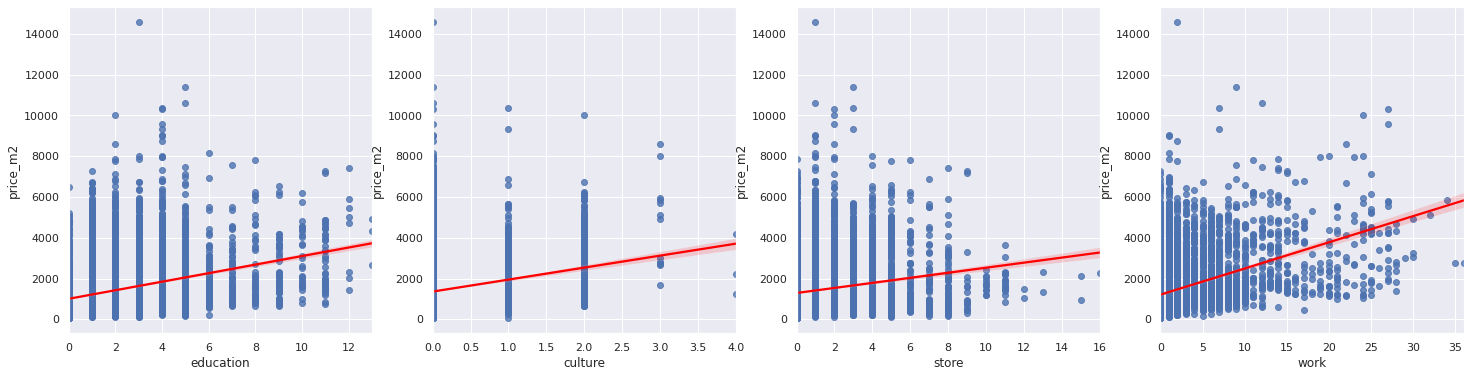

In [127]:
data = housing_data[housing_data.price < 1000000]

fig, axs = plt.subplots(1, 4, figsize=(25,6))
sns.regplot(x=data.education, y=data.price_m2, ax=axs[0], line_kws={'color':'red'})
sns.regplot(x=data.culture, y=data.price_m2, ax=axs[1], line_kws={'color':'red'})
sns.regplot(x=data.store, y=data.price_m2, ax=axs[2], line_kws={'color':'red'})
sns.regplot(x=data.work, y=data.price_m2, ax=axs[3], line_kws={'color':'red'})

> **<font color='Tomato'>Obs./Concluzie: </font>** Dupa cum se observa din graficul anterior, nu exista o corelatie puternica intre **pret/m2** si **educatie, cultura, magazine**, dar exista o corelatie pozitiva intre **pret/m2** si **munca**.

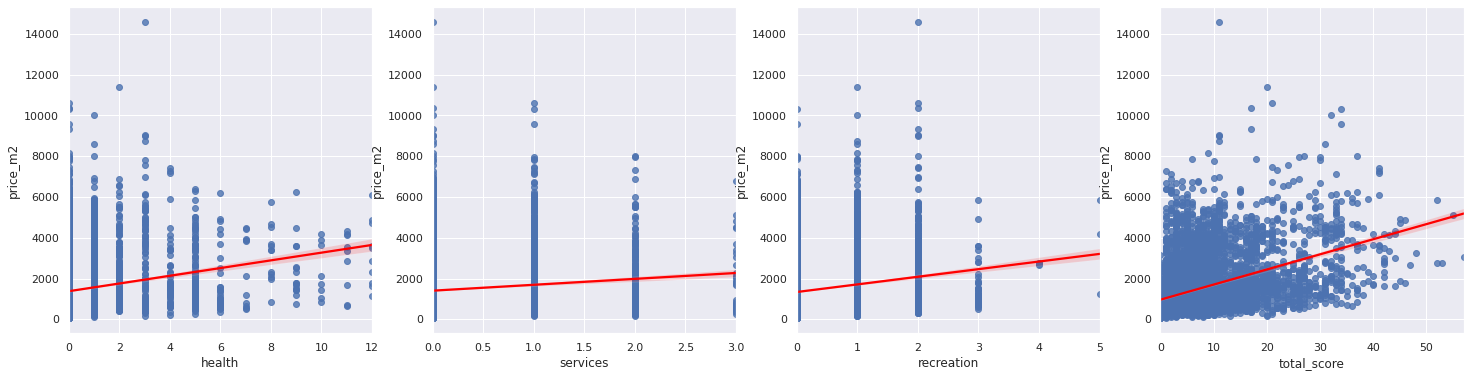

In [128]:
fig, axs = plt.subplots(1, 4, figsize=(25,6))
sns.regplot(x=data.health, y=data.price_m2, ax=axs[0], line_kws={'color':'red'})
sns.regplot(x=data.services, y=data.price_m2, ax=axs[1], line_kws={'color':'red'})
sns.regplot(x=data.recreation, y=data.price_m2, ax=axs[2], line_kws={'color':'red'})
sns.regplot(x=data.total_score, y=data.price_m2, ax=axs[3], line_kws={'color':'red'})

> **<font color='Tomato'>Obs./Concluzie: </font>** Dupa cum se observa din graficul anterior, nu exista o corelatie puternica intre **pret/m2** si **sanatate, servicii** si **recreatie**, dar exista o corelatie pozitiva inre **pret/m2** si numarul de utilitati **totale** din zona.

In [ ]:
!pip install geopandas shapely descartes

In [131]:
seattle_coord = (47.7511, 120.7401)

df = pd.DataFrame(
    {'City': "seattle",
     'Latitude': [seattle_coord[0]],
     'Longitude': [seattle_coord[1]]
                   })
df.head()

,City,Latitude,Longitude
0,seattle,47.7511,120.7401


In [132]:
usa = gpd.read_file("states/states.shp")

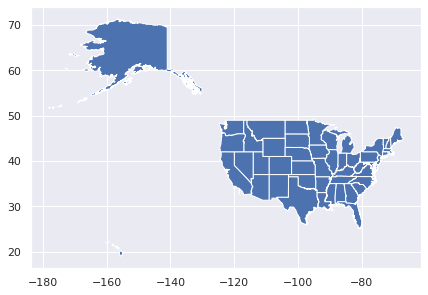

In [133]:
usa.plot()

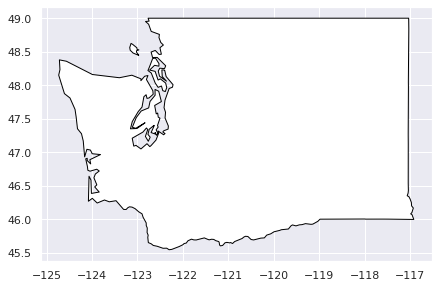

In [134]:
usa[usa.STATE_NAME == "Washington"].plot(color='white', edgecolor="black")

Preluarea bazei de date post-procesata, adaugarea locuintelor pe harta.

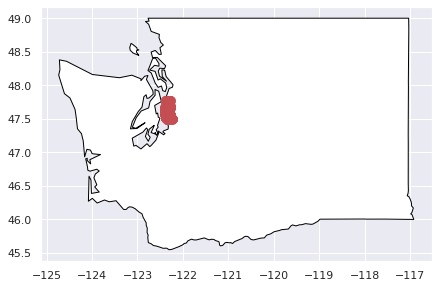

In [137]:
houses = pd.read_csv("https://raw.githubusercontent.com/jafetimbre/mib-fiesta/master/data/housing_data_cleaned.csv")

usa[usa.STATE_NAME == "Washington"].plot(color='white', edgecolor="black")
for i, row in houses.iterrows():
   plt.plot(row['long'], row['lat'], marker=".", color='r', markersize=15, alpha=0.25)
plt.show()

Focalizarea (zoom-in) pe Seattle, orasul in care se regasesc locuintele din dataset. Se creeaza un "gradient" in functie de pretul locuintelor, determinat de 6 categorii: "cele mai ieftine", "ieftine", "sub medie", "peste medie", "scumpe", "cele mai scumpe".

numar locuinte: 7981
7981
1330.1666666666667


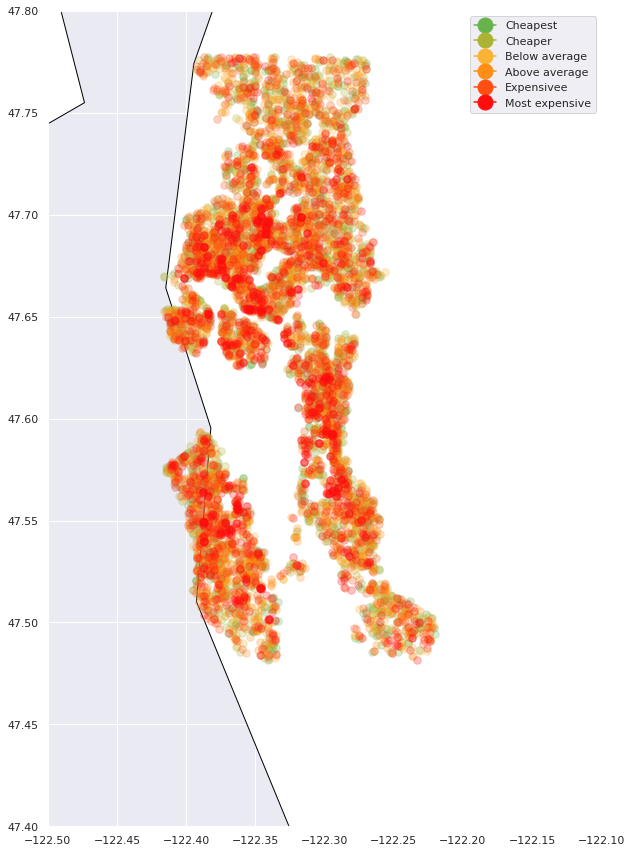

In [140]:
ax = usa[usa.STATE_NAME == "Washington"].plot(color='white', edgecolor="black", figsize=(20,15))
#ax.margins(x=-0.2, y=-0.45)
ax.set_xlim(-122.5, -122.1)
ax.set_ylim(47.4, 47.8)
gradient_arr = ['#69B34C', '#ACB334', '#FAB334', '#FF8E15', '#FF4E11', '#FF0D0D']
houses.sort_values(by=['price'])
row_numbers = len(houses['price'])
print("numar locuinte:", row_numbers)
separator = row_numbers / 6
print(len(houses))

print(separator)
for i, row in houses.iterrows():
    plt.plot(row['long'], row['lat'], marker=".", color=gradient_arr[math.floor(int(i/separator))], markersize=15, alpha=0.25)
cheapest_legend = Line2D([0], [0], marker='o', color='#69B34C', label='Cheapest',
                        markerfacecolor='#69B34C', markersize=15)
cheaper_legend = Line2D([0], [0], marker='o', color='#ACB334', label='Cheaper',
                        markerfacecolor='#ACB334', markersize=15)
below_legend = Line2D([0], [0], marker='o', color='#FAB334', label='Below average',
                        markerfacecolor='#FAB334', markersize=15)
above_legend = Line2D([0], [0], marker='o', color='#FF8E15', label='Above average',
                        markerfacecolor='#FF8E15', markersize=15)
expensive_legend = Line2D([0], [0], marker='o', color='#FF4E11', label='Expensivee',
                        markerfacecolor='#FF4E11', markersize=15)
most_exp_legend = Line2D([0], [0], marker='o', color='#FF0D0D', label='Most expensive',
                        markerfacecolor='#FF0D0D', markersize=15)
plt.legend(handles=[cheapest_legend, cheaper_legend, below_legend, above_legend, expensive_legend, most_exp_legend])
plt.show()


Distributia caselor in functie de anul construirii, determinat de 7 categorii: "Inainte de 1950", "1950-1960, "1960-1970", "1970-1980", "1980-1990", "1990-2000", "Dupa 2000". 

> **<font color='Tomato'>Obs./Concluzie: </font>** Din harta locuintelor in functie de pret si anul construirii, se observa faptul ca exista o corelatie directa, puternica intre cele doua campuri.

numar locuinte: 7981


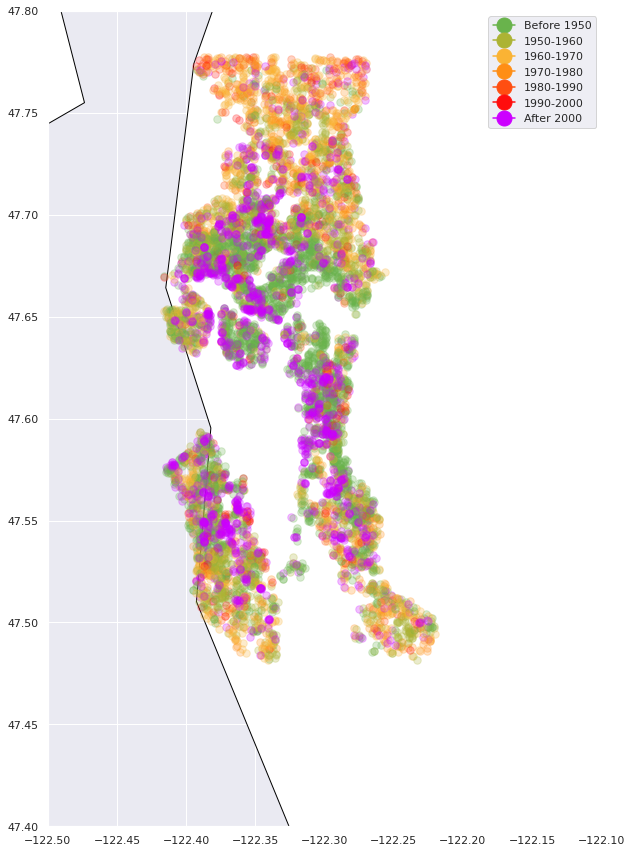

In [139]:
ax = usa[usa.STATE_NAME == "Washington"].plot(color='white', edgecolor="black", figsize=(20,15))
#ax.margins(x=-0.2, y=-0.45)
ax.set_xlim(-122.5, -122.1)
ax.set_ylim(47.4, 47.8)
gradient_arr = ['#69B34C', '#ACB334', '#FAB334', '#FF8E15', '#FF4E11', '#FF0D0D', '#CC00FF']
houses.sort_values(by=['price'])
row_numbers = len(houses['price'])
print("numar locuinte:", row_numbers)
separator = row_numbers / 6

for i, row in houses.iterrows():
  index = 0
  for j in range(1940, 2000, 10):
    if row['yr_built'] >= j:
      index = index + 1
  proper_color = gradient_arr[index]
  plt.plot(row['long'], row['lat'], marker=".", color=proper_color, markersize=15, alpha=0.25)
#plt.legend(['green', 'light green', 'light yellow', 'yellow', 'orange', 'red'], ['cheapest', 'cheaper', 'below average', 'above average', 'expensive', 'the most expensive']);
cheapest_legend = Line2D([0], [0], marker='o', color='#69B34C', label='Before 1950',
                        markerfacecolor='#69B34C', markersize=15)
cheaper_legend = Line2D([0], [0], marker='o', color='#ACB334', label='1950-1960',
                        markerfacecolor='#ACB334', markersize=15)
below_legend = Line2D([0], [0], marker='o', color='#FAB334', label='1960-1970',
                        markerfacecolor='#FAB334', markersize=15)
above_legend = Line2D([0], [0], marker='o', color='#FF8E15', label='1970-1980',
                        markerfacecolor='#FF8E15', markersize=15)
expensive_legend = Line2D([0], [0], marker='o', color='#FF4E11', label='1980-1990',
                        markerfacecolor='#FF4E11', markersize=15)
most_exp_legend = Line2D([0], [0], marker='o', color='#FF0D0D', label='1990-2000',
                        markerfacecolor='#FF0D0D', markersize=15)
last_legend = Line2D([0], [0], marker='o', color='#CC00FF', label='After 2000',
                        markerfacecolor='#CC00FF', markersize=15)
plt.legend(handles=[cheapest_legend, cheaper_legend, below_legend, above_legend, expensive_legend, most_exp_legend, last_legend])
plt.show()

In secventa de cod de mai jos, se vor categoriza locuintele in 3 categorii, evidentiind astfel diferenta in numarul de case construite in fiecare interval.

> **<font color='Tomato'>Obs./Concluzie: </font>** Un factor important in construirea unei locuinte noi este atat proximitatea la o sursa de apa cat si la centrul orasului.

Numarul de case construite intre 1900 si 1950: 4200
Numarul de case construite intre 1950 si 1990: 2012
Numarul de case construite dupa 1990: 1769


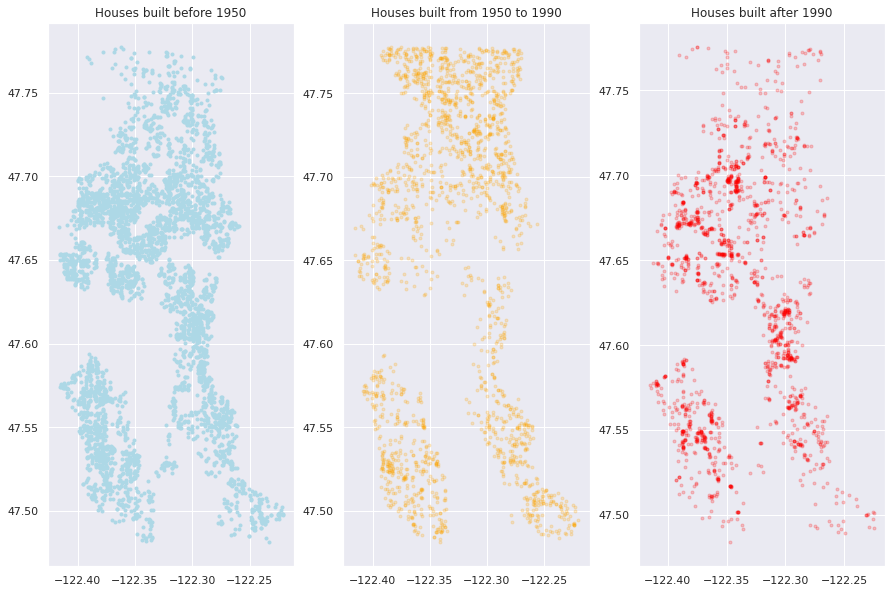

In [141]:
fig = plt.figure(figsize = (15,10))
lat_first = houses.loc[houses['yr_built'] <= 1950].lat
long_first = houses.loc[houses['yr_built'] <= 1950].long

lat_second = houses.loc[(houses['yr_built'] <= 1990) & (houses['yr_built'] > 1950)].lat
long_second = houses.loc[(houses['yr_built'] > 1950) & (houses['yr_built'] <= 1990)].long

lat_third = houses.loc[houses['yr_built'] > 1990].lat
long_third = houses.loc[houses['yr_built'] > 1990].long
print("Numarul de case construite intre 1900 si 1950:", len(lat_first))
print("Numarul de case construite intre 1950 si 1990:", len(lat_second))
print("Numarul de case construite dupa 1990:", len(lat_third))

ax2 = fig.add_subplot(131)
plt.scatter(long_first, lat_first, label = '<1950', color='lightblue', marker='.')
plt.title('Houses built before 1950')

ax3 = fig.add_subplot(132)
plt.scatter(long_second, lat_second, label = '1950-1990', color='orange', marker='.', alpha=0.2)
plt.title('Houses built from 1950 to 1990')

ax4 = fig.add_subplot(133)
plt.scatter(long_third, lat_third, label = '>1990', color='red', marker='.', alpha=0.2)
plt.title('Houses built after 1990')
plt.show()


Pentru urmatoarea secventa de cod, s-a folosit libraria Folium, care are scopul de manipulare a datelor si afisarea lor pe harta Leaflet. Din motive de performanta, s-a ales afisarea primelor 500 de case.

> **<font color='Tomato'>Obs./Concluzie: </font>** Cu trecerea timpului, vor fi tot mai putine case construite.

In [142]:
seattle_map = folium.Map(location=[47.656, -122.4],
                        zoom_start=12,
                        tiles='openstreetmap')
for i, row in houses.head(500).iterrows(): 
  lat = row['lat']
  long = row['long']
  mark = folium.Marker([lat, long]).add_to(seattle_map)
seattle_map

In harta de mai jos, se pot observa locuintele cu vedere la apa, avand ca pop-up pretul fiecarei case.

In [143]:
waterfront_houses = houses.loc[houses['waterfront'] == 1]
seattle_map = folium.Map(location=[47.656, -122.4],
                        zoom_start=12,
                        tiles='Stamen Toner')
for i, row in waterfront_houses.iterrows(): 
  lat = row['lat']
  long = row['long']
  popup_text = f"Price: {row['price']}"
  popup = folium.Popup(popup_text, parse_html=True)
  mark = folium.Marker([lat, long], popup=popup).add_to(seattle_map)
seattle_map

## 5. Concluzii

Datasetul, prin atributele numeroase, ofera posibilitati multiple de analiza.
Majoritatea ipotezelor noastre s-au confirmat. Cel mai surprinzator lucru fiind ca vechimea unei case nu afecteaza.

In final am ajuns la concluzia ca in setul de date curent, numarul serviciilor  din raza proprietatiolor nu influenteaza pretul acestora.


In [179]:
print('The end')

The end
